In [34]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance



from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# No Hope for Post-Hoc Interpretability?

## Can a better understanding of training data address sampling & locality problems with LIME ?

Post-hoc interpretability methods have recently dominated the explainable AI converstaion with exciting advancements including:
<ul>
    <li> Locally Interpretable Model Agnostic Explanations (LIME) Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin (2016) </li>
            <li> Shapley Value inspired explanations (SHAP) Lundberg, Scott M., and Su-In Lee (2017) </li>
        <li> Partial Dependence Plots, Friedman, Jerome H (2001)
   
   </ul>
    
The main advantage of post-hoc interpretability is that it has minimal assumptions about the underlying predictive model allowing for flexibility. Furthermore, many post-hoc interpretability methods do not focus on understaning the original training data, completely isolating explanation from development. This is preferebale for individual users of a system who wish to query a particular decision of the algorithm. However, this particular application is often touted as the gold standard of explainability. Through this work, we challenge this assumption, highlighting other parts of the explainability pipeline and question whether explainability <b> should </b> be performed after model design, development and learning. 

Alongside their popoularity, post-hoc interperetability methods have also provoked recent debate surrounding their trustworithiness. This is a result of their main disadvantage which unfortunately, comes as the other side of the coin to their flexibility: their lack of fidelity to the original black box model. As a result of this, many recent studies have explored and proved various robustness issues with post-hoc interpretability. 

Some have even gone so far as to argue that post-hoc interpretability methods cant be trusted at all for explanations (Rudin, 2019). 

We explore this idea by considering some limitations with post-hoc models. We argue that by incorporating more detailed knowledge of the training data, post-hoc intepretability methods can be contextualised improved.


## Explainability Pipeline 

Post-hoc explanations are generated after the machine learning algorithm has been trained. There is also a significant body of research currrently being undertaken exploring how to generate explanations during the training process (Koh and Liang 2017). Surprisingly (at least to me) is the lack of research surrounding explainability prior to model development particularly regarding the interpretability of the data and feature engineering.  Thanks to the <it> no free lunch </it> theorem, we know that many assumptions are encoded in the decisions made before a model is trained. A complete understanding of the 
data is therefore critical in making sure the correct research question is asked and the correct statistical methdoology can be applied. 

This work begins by exploring some of the problems with local sampling in post-hoc models. We then lok at how generative models of the original training data could be used to resolve these issues. Ultimately,  we attempt to bridge the gap between an understanding of the underlying data distributions and post-hoc interpretability. 




## Dataset

We start by downloading the "Tennis Major Tournament Match Statistics Data Set" available from the UCI data repository at URL: https://archive.ics.uci.edu/ml/datasets/Tennis+Major+Tournament+Match+Statistics. 

The dataset contains the results of 100 tennis matches between 2 players, with the result indiciating whether Player 1 won or or lost the match alonsgide various characteristics about the match including serve percentage, ace percentage, double fauls...etc. The feature set is detailed in full at URL: https://archive.ics.uci.edu/ml/datasets/Tennis+Major+Tournament+Match+Statistics.

In [35]:
raw_tennis_df = pd.read_csv('data/AusOpen-men-2013.csv')

#for (columnName, columnData) in tennis_df.iteritems():
tennis_df = raw_tennis_df.fillna(0) 
tennis_df.head()

,Player1,Player2,Round,Result,FNL1,FNL2,FSP.1,FSW.1,SSP.1,SSW.1,...,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2
0,Lukas Lacko,Novak Djokovic,1,0,0,3,61,35,39,18,...,4,8,8.0,9.0,101,6,7.0,6.0,0.0,0.0
1,Leonardo Mayer,Albert Montanes,1,1,3,0,61,31,39,13,...,0,0,0.0,0.0,42,1,3.0,1.0,0.0,0.0
2,Marcos Baghdatis,Denis Istomin,1,0,0,3,52,53,48,20,...,4,13,12.0,16.0,126,6,7.0,6.0,0.0,0.0
3,Dmitry Tursunov,Michael Russell,1,1,3,0,53,39,47,24,...,1,7,0.0,0.0,79,2,2.0,3.0,0.0,0.0
4,Juan Monaco,Ernests Gulbis,1,0,1,3,76,63,24,12,...,3,5,16.0,28.0,127,1,6.0,7.0,6.0,0.0


We then train a Random Forest Classifier using all numerical columns as features to predict whether ``Player1`` won the game.

In [36]:
Original_X = tennis_df.select_dtypes(include='number').drop('Result',axis=1).values
X = tennis_df.select_dtypes(include='number').drop('Result',axis=1).values
y = tennis_df['Result'].values
y_original = tennis_df['Result'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

We then compute the global interpretability metric: permutation feature importance (PFI) that calculates the relative importance of each feature vector in the overall prediction. PFI achieves this by computing the change in prediction error from randomly permuting each feature in turn. 

We then use the results to select the best two features and two of the worst features and visualise these below under a selection of classifiers.


In [38]:
feature_importance = permutation_importance(clf, X_train, y_train, n_repeats=3
                                           )
chosen_indexes = feature_importance.importances_mean.argsort()[-2:][::-1]

# Chosen indexes are ST2.2 and FNL2

In [39]:
new_X = X[:, chosen_indexes]
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=42)

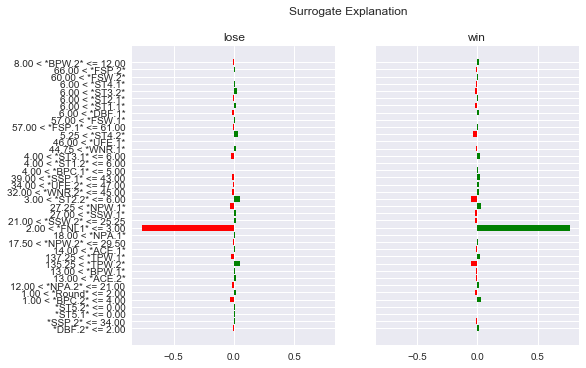

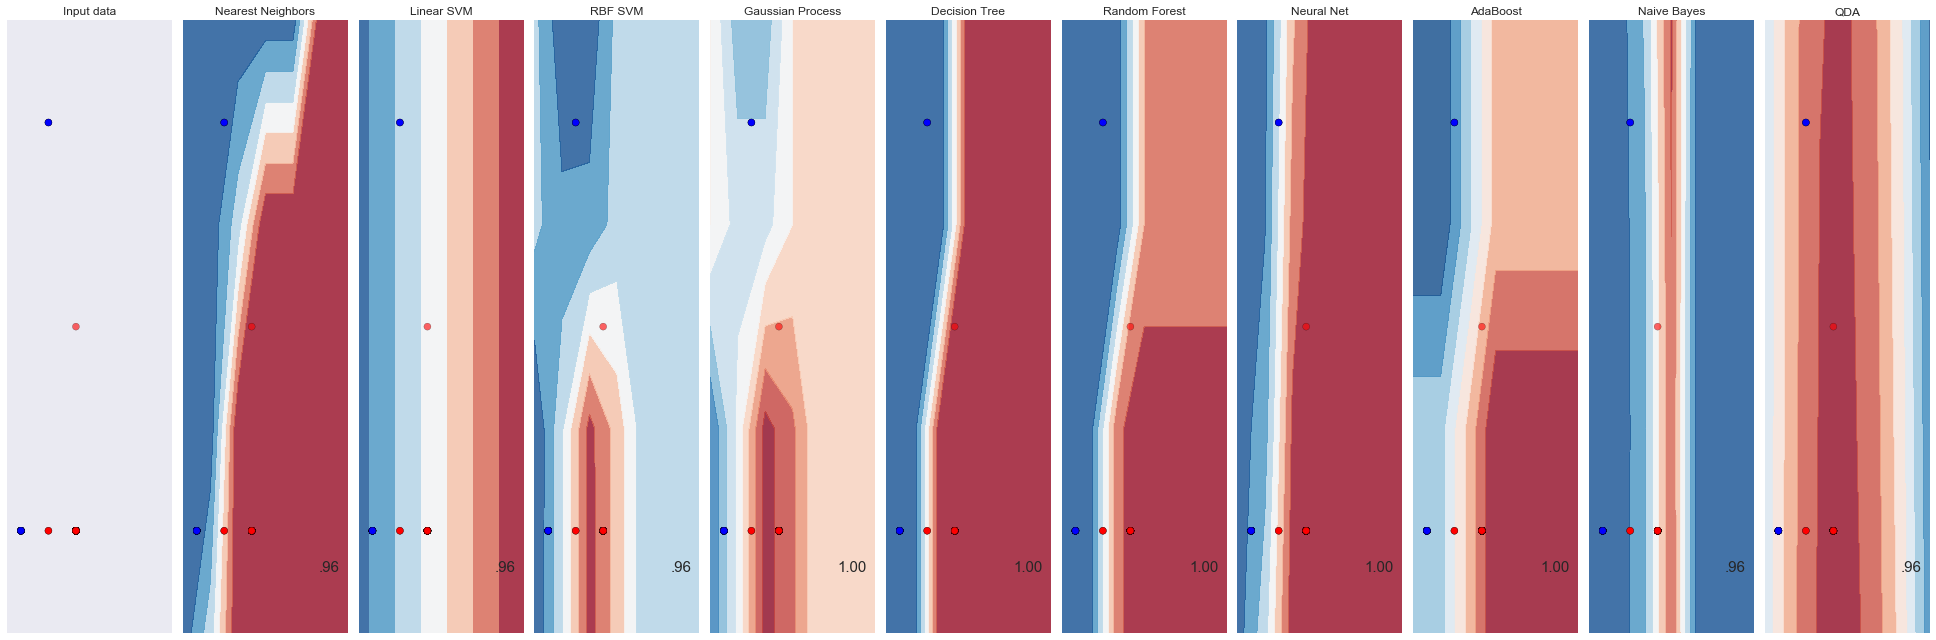

In [40]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


figure = plt.figure(figsize=(27, 9))
i = 1

# preprocess dataset, split into training and test part

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max),
                     np.arange(y_min, y_max))


# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)

ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()

In [41]:
X = tennis_df[['FSP.1', 'FSW.1']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

45.5
82.5
13.5
109.5


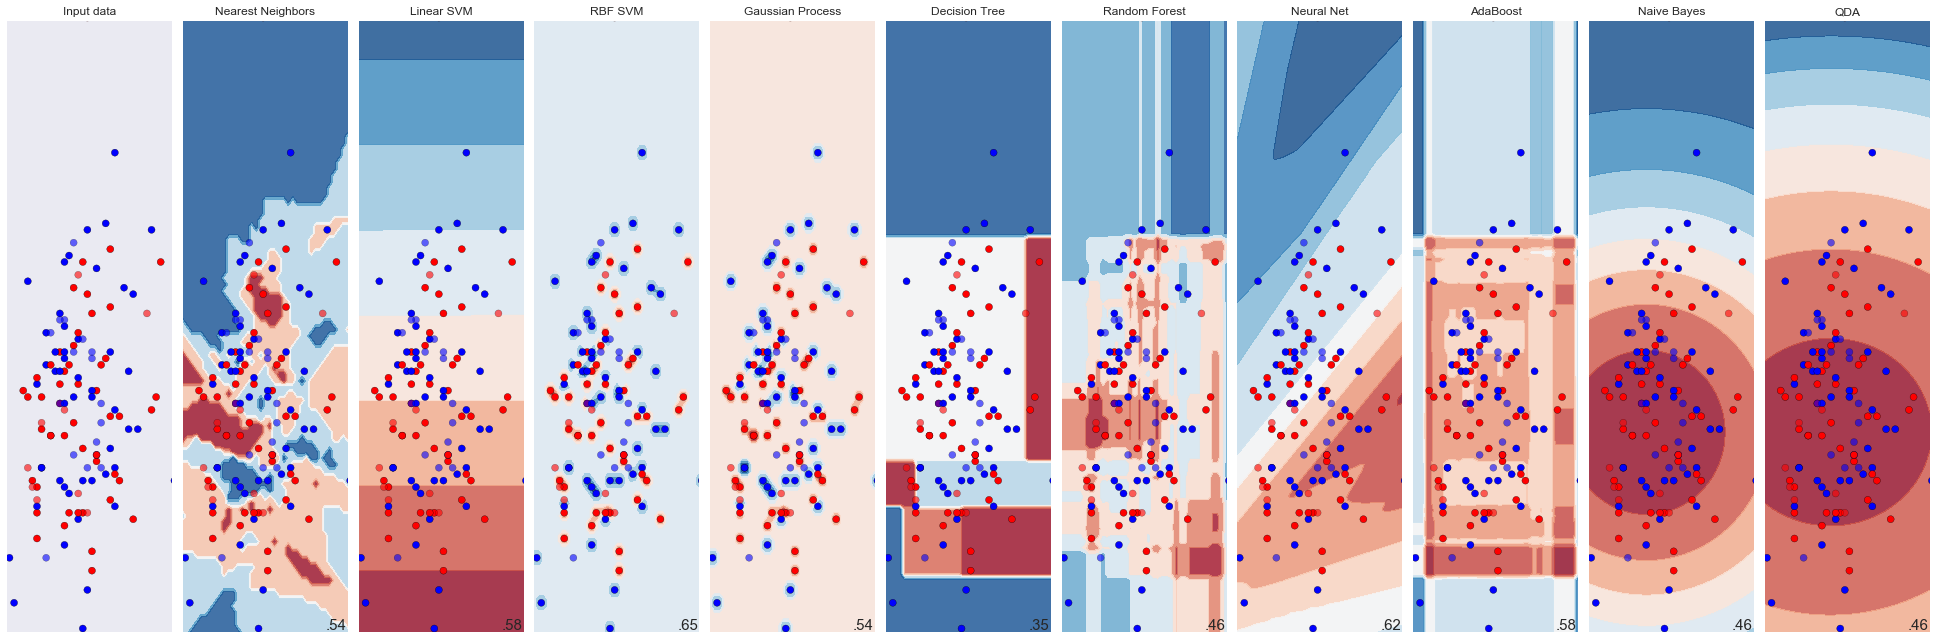

In [42]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


figure = plt.figure(figsize=(27, 9))
i = 1

# preprocess dataset, split into training and test part

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max),
                     np.arange(y_min, y_max))

print(x_min)
print(x_max)
print(y_min)
print(y_max)

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()

The results show how important feature selection is in the classification task. With the best two features under PFI giving a predictive accuracy of 1 and the bottom two features according to PFI a predictive accuracy of 62

## Exploring LIME 

We now explore how LIME calcalates feature importance for the tennis dataset. We first train a AdaBoostClassifier on all the numerical feature vectors from the tennis dataset and use this to predict the labels for our test set. As LIME is a localised feature importance model, we then arbitrarily select two particular instances of the same class to compare explanations for.

20-Jul-20 18:33:12 fatf.transparency.predictions.surrogate_explainers INFO     Selecting 39 features with highest weights.


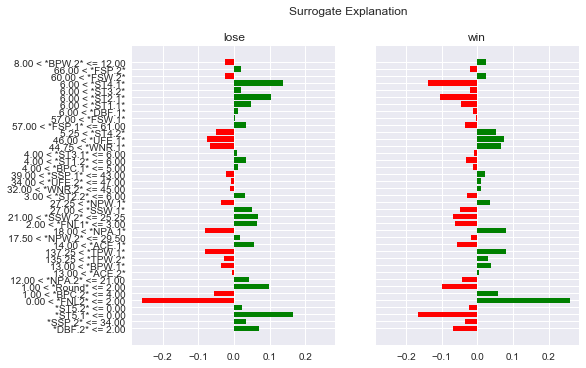

In [43]:
import fatf
import fatf.transparency.predictions.surrogate_explainers as fatf_surrogates
import fatf.vis.lime as fatf_vis_lime


X_train, X_test, y_train, y_test = train_test_split(Original_X, y, test_size=0.2, random_state=42)
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
tennis_feature_names= list(tennis_df.select_dtypes(include='number').drop('Result',axis=1).columns) 
index_names = [str(x) for x in np.arange(0,39)]
class_names = ['lose', 'win']
predictions = clf.predict(X_test)
clf.score(X_test,y_test)


# Create a LIME explainer
lime = fatf_surrogates.TabularBlimeyLime(
    X_train,
    clf,
    feature_names= tennis_feature_names,
    class_names=class_names)

# Explain an instance
lime_explanation = lime.explain_instance(
    X_test[0, :], samples_number=500)


# Plot the explanation
fatf_vis_lime.plot_lime(lime_explanation)

20-Jul-20 18:33:14 fatf.transparency.predictions.surrogate_explainers INFO     Selecting 39 features with highest weights.


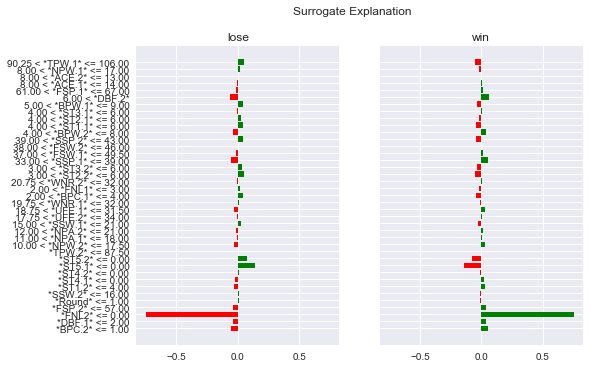

In [44]:
# Explain an instance
lime_explanation = lime.explain_instance(
    X_test[1, :], samples_number=500)


# Plot the explanation
fatf_vis_lime.plot_lime(lime_explanation)

In [45]:
tennis_df.head()


,Player1,Player2,Round,Result,FNL1,FNL2,FSP.1,FSW.1,SSP.1,SSW.1,...,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2
0,Lukas Lacko,Novak Djokovic,1,0,0,3,61,35,39,18,...,4,8,8.0,9.0,101,6,7.0,6.0,0.0,0.0
1,Leonardo Mayer,Albert Montanes,1,1,3,0,61,31,39,13,...,0,0,0.0,0.0,42,1,3.0,1.0,0.0,0.0
2,Marcos Baghdatis,Denis Istomin,1,0,0,3,52,53,48,20,...,4,13,12.0,16.0,126,6,7.0,6.0,0.0,0.0
3,Dmitry Tursunov,Michael Russell,1,1,3,0,53,39,47,24,...,1,7,0.0,0.0,79,2,2.0,3.0,0.0,0.0
4,Juan Monaco,Ernests Gulbis,1,0,1,3,76,63,24,12,...,3,5,16.0,28.0,127,1,6.0,7.0,6.0,0.0


While our results show that LIME aligns with PFI in its indication that FNL2 is the most important metric for both instances, it does not align with PFI in the importance of ST2.2. Furthermore, and perhaps more worrying, LIME is capable of generating very different explanations containing very different feature importances for individual instances despite these instances belonging to the same class. Particularly concerning here are feature importances for features such as ST2.1 which indicate oppostite effects on prediction for each instance despite both instances belonging to the same class. These problems are indicative of the non-robust nature of interpetability metrics such as PFI and LIME. They have been acknowledged and discussed extensively in the literature CITE. 

This particular body of research is going to look further into the particular problems LIME has with <b> sampling </b> and <b> distance metrics </b>. We do so below.

## Mechanics of LIME

Within this research we are using the implementation of LIME from the FAT Forensics library from [SOKOL2019PYTHON]. For an in depth discussion of how LIME works, you can read the original paper, [RIBEIRO2016WHY], we provide a simplistic overview below:

LIME explains the prediction of a particular instance given a pre-trained model. It works by fabricating a number of instances around the given instance in feature space. It then uses the original model to predict the target parameter of the fabricated instances. It then trains a simple regression model on these fabricated instances and labels and outputs the co-efficients as feature importances, weighting them according to how close they are in feature space to the instance being explained. 

Focusing on Tabular Data

We are now going to dive a little deeper into the mechanics of the Python implementation of LIME to explore how sampling and "local" problems may arise:

The continuous feature vectors from the original training are first binned and discretised, the categorical feature vectors are kept as is. 

The data is then sampled from the corresponding bin of the discretised feature values of the instance to be explained. The sampler used by Fat forensics is the truncated normal sampler which uses the empirical mean, standard deviation from all the data points from the original training dataset for which feature values fall into that bin. A binary vector is then calculated for each sampled feature vector with a value of 1 if the sampled feature value is the same as the instance feature value and 0 otherwise. The Euclidean distance between the binarised sample feature vector and the binarised input instance is then calculated which is then used as similarity scores to weight the importance of each sampled data point in its contribution to feature importance. A local ridge regression model is then fitted on the binarised, discretised sampled feature vectors and their associated target variable. The associated target variable is calculated by running original fitted model on the sampled feature vectors (transformed back to the domain of the model).

## LIME and Sampling

<ul> 
    <li> <b> Sampling from the interpretable representations </b>
As reported in [SOKOL2019BLIMEY] to avoid unwanted randomness in the explanations, the function that maps the data into its intepretable representation must be bijective and must have a uniquely defined inverse funciton. While this is trivial for text and image data, for continuous tabular data this poses a problem. In order to define an interpretable representation for continuous features,  LIME relies on discretising the continuous data into bins. This clearly does not provide a unique inverse. How do I get from a bin (e.g.  $x < 7$) back to its original continuous value?.  LIME overcomes this problem by using a normal sampler within the associated bin to get back the sampled data point in its original domain. </li> 
       <li> <b> Discretising continuous data </b>
        Reducing the dimensionality of tabular data by converting the original input domain to an interpretable representation is necessary to provide meaningful explanations to the user. The conversion of the input domain to the interpretable feature space also preserves locality: LIME works by diregarding the interpretable features that have a value of 0 for the instance to be explained. This ensures locality by only quantifying the (positive or negative) effect of changing any of the interpretable feature ranges within which the explained data point resides. [SOKOL2019BLIMEY] claims that: "An interpretable representation for tabular data may be skipped altogether in which case other modules of the surrogate explainer, like the data sampler, should guarantee the locality of an explanation." </li> 
        <li> <b> Sampling from the original domain </b>
        Alternatively, for tabular data the above problem could be alleviated by first sampling a data point in its original domain and then converting to an interpretable representation. [SOKOl2019BLIMEY] highlights that for this approach to produce meanginful explanations, the sampling has to be as local as possible. Also claims that: "Furthermore, sampling in this domain requires the sampling method to produce data points that are assigned more than one class (or significantly different class probabilities for probabilistic models) by the black-box model, otherwise a meaningful local surrogate model cannot be fitted." <b> </b> </li>
    </ul>
      

One of the main disadvantages of the sampling metric employed by LIME is by ignoring the structure of the original training dataset, the explanations ignore the covariance between features. We exemplify this below. 



In [46]:
## Plot the correlation between features in the tennis dataset

In [47]:
feature_df = tennis_df.select_dtypes(include='number').drop(['Result'],axis=1)

In [48]:
feature_df.head()

,Round,FNL1,FNL2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,...,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2
0,1,0,3,61,35,39,18,5,1.0,17,...,4,8,8.0,9.0,101,6,7.0,6.0,0.0,0.0
1,1,3,0,61,31,39,13,13,1.0,13,...,0,0,0.0,0.0,42,1,3.0,1.0,0.0,0.0
2,1,0,3,52,53,48,20,8,4.0,37,...,4,13,12.0,16.0,126,6,7.0,6.0,0.0,0.0
3,1,3,0,53,39,47,24,8,6.0,8,...,1,7,0.0,0.0,79,2,2.0,3.0,0.0,0.0
4,1,1,3,76,63,24,12,0,4.0,16,...,3,5,16.0,28.0,127,1,6.0,7.0,6.0,0.0


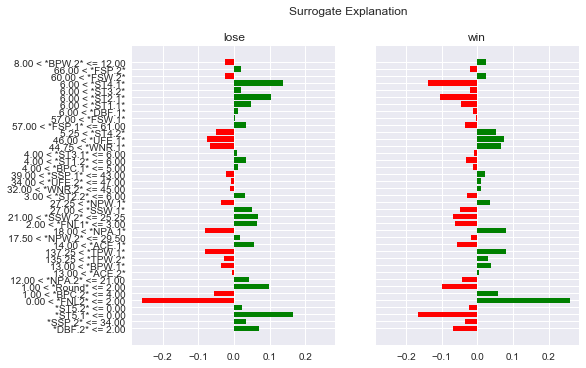

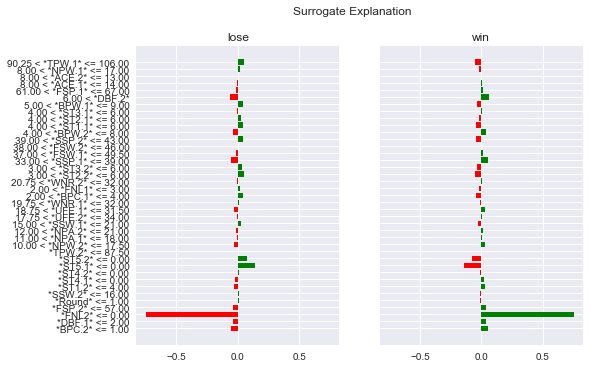

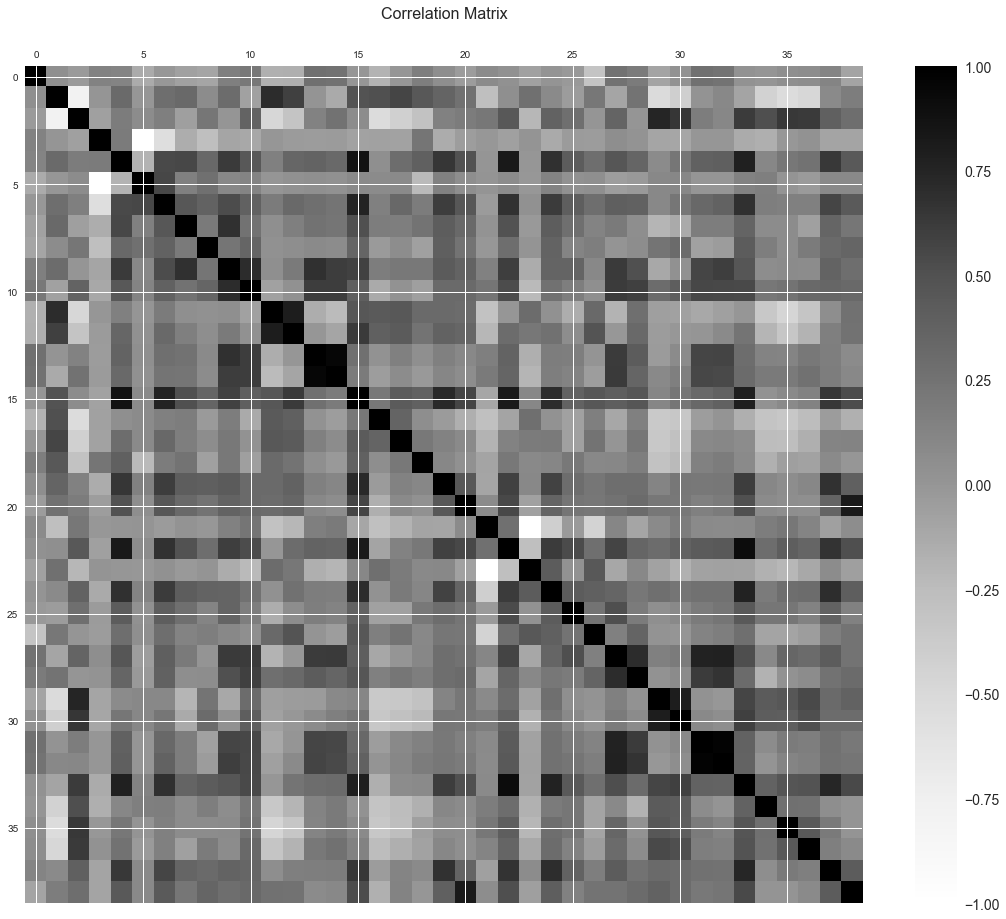

In [49]:
f = plt.figure(figsize=(19, 15))
plt.matshow(feature_df.corr(), fignum=f.number)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

plt.show()

Our correlation matrix shows that there is a high amount of correlation between the different features of our dataset. Lets, take feature 1 and feature 2 which equate to FNL1 and FNL2 in the tennis dataset. The above matrix shows that these two features have a negative correlation nearing -1. This is interesting as LIME (and PFI) showed FNL2 to be an important feature and FNL1 as to be non-important. 

Let's try removing FNL2 from the feature set to see what this effect this has on our explanations 

20-Jul-20 18:33:18 fatf.transparency.predictions.surrogate_explainers INFO     Selecting 38 features with highest weights.


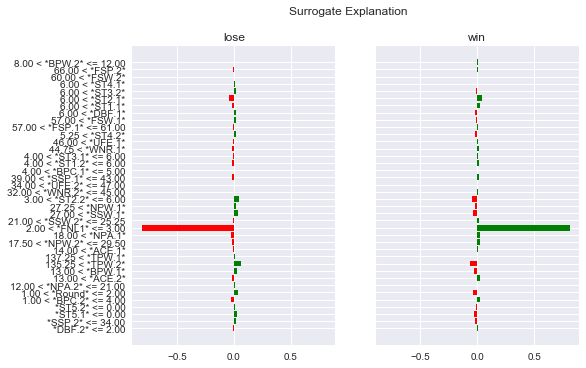

In [50]:
dropped_feature_X = tennis_df.select_dtypes(include='number').drop(['Result','FNL2'],axis=1).values
X_train, X_test, y_train, y_test = train_test_split(dropped_feature_X, y, test_size=0.2, random_state=42)
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
tennis_feature_names= list(tennis_df.select_dtypes(include='number').drop(['Result','FNL2'],axis=1).columns) 
index_names = [str(x) for x in np.arange(0,38)]
class_names = ['lose', 'win']
predictions = clf.predict(X_test)
clf.score(X_test,y_test)


# Create a LIME explainer
lime = fatf_surrogates.TabularBlimeyLime(
    X_train,
    clf,
    feature_names= tennis_feature_names,
    class_names=class_names)

# Explain an instance
lime_explanation = lime.explain_instance(
    X_test[0, :], samples_number=500)


# Plot the explanation
fatf_vis_lime.plot_lime(lime_explanation)

The above explanation shows that by removing FNL2 from the fetaure set, FNL1 is now the most important feature for the local explanation. These results show that LIME cannot successfully share the importance between correlated features creating unstable explanations that we may find difficult to trust.

Ideally, we would want our explanation model to capture the relations between features. This has been attempted a number of ways in the literature CITE HERE. 

This work attempts to buid a generative model of the data that captures the relationships between features. 


## LIME and Locality

How does definition of locality affect explanations?

We have seen above how the choice in sampling technique directly affects the locality of the LIME implementation. By choosing to sample after the data has been transformed into its interpretable representation (commonly referred to as 'local sampling' and encouraged by [LAUGEL2018LOCALITY]), LIME measures the Euclidean distance between the transformed sample feature vector and the transformed instance to be explained to weight the resulting explanations. 

Originally, the LIME implentation detailed above was different, such that the sampling occurred in the data's original domain and a kernel (default Gaussian) was used to measure the distance between samples and the instance to be explained in high dimensiona feature space. Both approaches affect the locality of the explaantions and the associated bias encoded in the explanations. We detail some of these below:

<ul> 
    <li> The curse of dimensionality affects distance metrics between data points in high dimensional space: data points are increasingly spread out in high dimensional space that may affect the resulting 'local' weighting. </li>
   <li> The choice of kernel, most importantly, the width of the kernel greatly impacts the resulting explanation - too wide and the explanation is global, too narrow and the explanation loses stability in that every newly generated explanation is different. </li>
</ul>
    
    
TODO: More experiments





The discussion above shows that there is a trade off between stability and locality of explanations - we explore below an approach that tries to generate a global understanding of the training data through a generative model and uses this to provide weighted local explanations using a Fisher kernel that is the associated  kernel for generative probabilistic models.

## Building a Generative Model of the Training Data

One of the key issues highlighted by our analysis of the LIME sampling mechanism was the lack of a holistic understanding of the underlying data distribution. By sampling individually for each feature we break the relationship between features. We also may end up with unrealistic feature vectors which contribut mto the instability of LIME. 

We now relate this problem back to the topics discussed in the Introduction. We believe that a better understanding of the original dataset will help us solve some of the instability problems associated with LIME. For an in depth discussion of what it means to understand data please see our piece LINK HERE. 

For the purposes of this particular research we propose to equate an understanding of the data with a generative model of the underlying data process. We start by generating a Gaussian Mixture Model that captures the covariance between features and use this likelihood model to sample data points around our instance to be explained. 

## Gaussian Mixture Model

## Fisher Kernel to Weight Samples 

We have discussed above how to sample for our local explanation using  better understanding of the original dataset. However, there still remains the challenge of understanding how to measure the "distance" between these samples and the instance to be explained. 

We discussed above how the choice of kernel and associated parameters affects the explanation generated by LIME. We propose the use of a Fisher Kernel, that is built from a probabilistic model of the underlying data that we hope will adress some of the afroementioned issues. 

## Fisher Kernel

## References

<ul>
    <li> [RIBEIRO2016WHY] Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "" Why should I trust you?" Explaining the predictions of any classifier." Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining. 2016. </li>
    <li> Lundberg, Scott M., and Su-In Lee. "A unified approach to interpreting model predictions." Advances in Neural Information Processing Systems. 2017 </li>
    <li> Friedman, Jerome H. "Greedy function approximation: A gradient boosting machine." Annals of statistics (2001): 1189-1232. </li>
    <li> Koh, Pang Wei  and Liang, Percy, Understanding Black-box Predictions via Influence Functions, International Conference on Machine Learning (ICML), 2017.</li>
    <li>
        Rudin, Cynthia. "Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead." Nature Machine Intelligence 1.5 (2019): 206-215. </li>
    <li> [SOKOL2019PYTHON] Sokol, Kacper, Raul Santos-Rodriguez, and Peter Flach. "FAT Forensics: A Python toolbox for algorithmic fairness, accountability and transparency." arXiv preprint arXiv:1909.05167 (2019). </li>
    <li>[LAUGEL2018LOCALITY] Laugel, Thibault, et al. "Defining locality for surrogates in post-hoc interpretablity." arXiv preprint arXiv:1806.07498 (2018). </li>
    <li> [SOKOL2019BLIMEY] Sokol, K., Hepburn, A., Santos-Rodriguez, R., and Flach, P. (2019). bLIMEy: surrogate prediction explanations beyond LIME. arXiv preprint arXiv:1910.13016. </li>
    
</ul>